# Youtube channel comments sentiment analysis using BERT

In [2]:
from googleapiclient.discovery import build
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize APIs
api_key = "API key"
youtube = build('youtube', 'v3', developerKey=api_key)
analyzer = pipeline("sentiment-analysis")

def get_video_comments(video_id, max_comments=50):
    comments = []
    request = youtube.commentThreads().list(
        part="snippet",
        videoId=video_id,
        maxResults=min(max_comments, 100),
        textFormat="plainText"
    )
    response = request.execute()
    
    for item in response.get("items", []):
        comment = item["snippet"]["topLevelComment"]["snippet"]["textDisplay"]
        comments.append(comment)
    
    return comments

def analyze_comments(video_id):
    comments = get_video_comments(video_id)
    results = []

    for text in comments:
        sentiment = analyzer(text[:512])[0]
        print(f"{text[:60]}... → {sentiment['label']} ({sentiment['score']:.2f})")
        results.append({
            "comment": text,
            "sentiment": sentiment["label"],
            "score": sentiment["score"]
        })

    df = pd.DataFrame(results)

    # Plot sentiment distribution
    plt.figure(figsize=(6, 4))
    sns.countplot(x="sentiment", data=df, palette="Set2")
    plt.title("Sentiment Distribution")
    plt.ylabel("Number of Comments")
    plt.tight_layout()
    plt.show()

    return df


No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


In [3]:
request = youtube.search().list(
    q="@DancingBacons",  # Replace with the actual handle
    type="channel",
    part="snippet",
    maxResults=1
)
response = request.execute()

print(response['items'][0]['snippet']['channelId'])  # This gives the correct channel ID


UCRFj4Yj1nKhgrT-_8AUsaDg


In [4]:
def get_channel_video_ids(channel_id, max_results=5):
    # Get the Uploads playlist ID for the channel
    res = youtube.channels().list(
        id=channel_id,
        part='contentDetails'
    ).execute()

    if not res['items']:
        print("Invalid or private channel ID.")
        return []

    uploads_playlist_id = res['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    # Fetch videos from the uploads playlist
    playlist_items = youtube.playlistItems().list(
        playlistId=uploads_playlist_id,
        part='snippet',
        maxResults=max_results
    ).execute()

    video_ids = [item['snippet']['resourceId']['videoId'] for item in playlist_items['items']]
    return video_ids


This video is awesome.... → POSITIVE (1.00)
OK, I unsubscribed but then I watched this and subscribed ag... → POSITIVE (0.99)
the price may be sgd12... → NEGATIVE (0.96)
Would you review halal food?... → NEGATIVE (0.92)
😊😊😊... → NEGATIVE (0.70)
Why your not making street food... → NEGATIVE (1.00)
That beef was still mooing... → NEGATIVE (0.97)
That burger looks beyond discusting... → POSITIVE (0.60)
9:15 You Maniac... → NEGATIVE (0.88)
left4dead, excellent choice... → POSITIVE (1.00)
is that himouto umaru-chan at the entrance?... → NEGATIVE (1.00)
Imouto chan... → POSITIVE (0.94)
would live... → POSITIVE (1.00)
The cheapest room on some random internet cafe in China has ... → NEGATIVE (1.00)
0:08 Anyone know that character cutout?
And 0:28?... → NEGATIVE (1.00)
I’m afraid they will start banning durian after this lol... → NEGATIVE (1.00)
Wait! Its ikuyo in the beginning! lol... → NEGATIVE (1.00)
Must. 
Have. 
Big. 
Burger.... → NEGATIVE (0.61)
Those burgers look like they coulda been c

C:\Users\nocti\AppData\Local\Temp\ipykernel_3624\567568078.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="sentiment", data=df, palette="Set2")


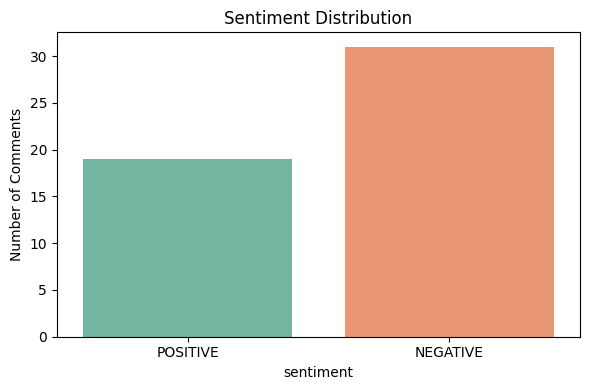

In [5]:
channel_id = "UCRFj4Yj1nKhgrT-_8AUsaDg"
video_ids = get_channel_video_ids(channel_id)

if video_ids:
    df = analyze_comments(video_ids[0])  # Analyze comments on the first video


# Using distilbert-base-uncased-finetuned-sst-2-english

Device set to use cpu


                                             comment sentiment  score
0                             This video is awesome!  POSITIVE   1.00
1                           That was hilarious, lol!  POSITIVE   1.00
2  OK, I unsubscribed but then I watched this and...  NEGATIVE   0.98
3                      That burger looks disgusting.  NEGATIVE   1.00
4                               9:15 You Maniac... 😂  POSITIVE   0.80
5           Wait! Its ikuyo in the beginning! lol...  POSITIVE   0.80
6  Looked comfy then I thought about how it must ...  POSITIVE   0.99
7                 Welcome to the Masturbatorium... 🤣  POSITIVE   1.00
8                        That’s literally a mukbang.  NEGATIVE   0.99
9  I'm afraid they'll start banning durian after ...  POSITIVE   0.80


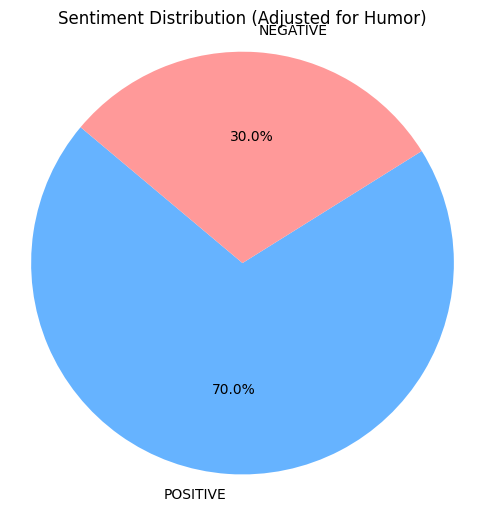

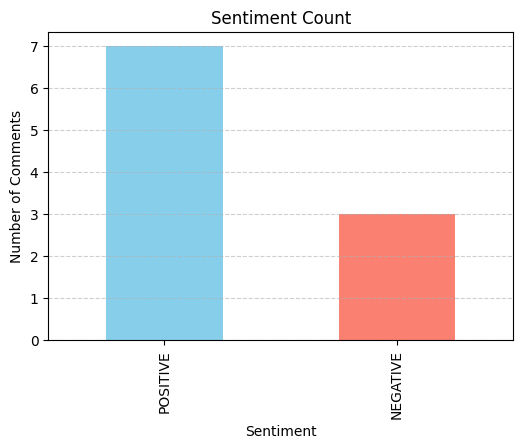

In [1]:
#Using sample of comments to test 
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt

# Load sentiment analyzer (BERT)
analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

HUMOR_KEYWORDS = ['lol', 'lmao', '😂', '🤣', 'haha', 'ikuyo', 'wtf', 'omg', 'that’s crazy', 'wtf', 'lmaoo']

# Example YouTube comments
comments = [
    "This video is awesome!",
    "That was hilarious, lol!",
    "OK, I unsubscribed but then I watched this and subscribed again.",
    "That burger looks disgusting.",
    "9:15 You Maniac... 😂",
    "Wait! Its ikuyo in the beginning! lol...",
    "Looked comfy then I thought about how it must smell in there.",
    "Welcome to the Masturbatorium... 🤣",
    "That’s literally a mukbang.",
    "I'm afraid they'll start banning durian after this lol."
]

def adjust_sentiment_for_humor(text, sentiment, score):
    if sentiment == "NEGATIVE" and any(kw in text.lower() for kw in HUMOR_KEYWORDS):
        return "POSITIVE", min(score, 0.80)
    return sentiment, score

def analyze_comments_with_humor(comments):
    results = []
    for comment in comments:
        result = analyzer(comment[:512])[0]
        sentiment, score = adjust_sentiment_for_humor(comment, result['label'], result['score'])
        results.append({
            "comment": comment,
            "sentiment": sentiment,
            "score": round(score, 2)
        })
    return pd.DataFrame(results)

# Run the analysis
df = analyze_comments_with_humor(comments)
print(df)

# Visualization
def visualize_sentiment(df):
    sentiment_counts = df['sentiment'].value_counts()
    
    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
    plt.title("Sentiment Distribution (Adjusted for Humor)")
    plt.axis('equal')
    plt.show()

    # Bar plot
    plt.figure(figsize=(6, 4))
    df['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title("Sentiment Count")
    plt.xlabel("Sentiment")
    plt.ylabel("Number of Comments")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()

# Show charts
visualize_sentiment(df)


In [6]:
#Getting commments form youtube 
from transformers import pipeline
import pandas as pd

analyzer = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

HUMOR_KEYWORDS = ['lol', 'lmao', '😂', '🤣', 'haha', 'ikuyo', 'wtf', 'omg', 'that’s crazy', 'wtf', 'lmaoo']

def adjust_sentiment_for_humor(text, sentiment, score):
    if sentiment == "NEGATIVE" and any(kw in text.lower() for kw in HUMOR_KEYWORDS):
        return "POSITIVE", min(score, 0.80)
    return sentiment, score

def analyze_comments_with_humor(comments):
    results = []
    for comment in comments:
        result = analyzer(comment[:512])[0]
        sentiment, score = adjust_sentiment_for_humor(comment, result['label'], result['score'])
        results.append({
            "comment": comment,
            "sentiment": sentiment,
            "score": round(score, 2)
        })
    return pd.DataFrame(results)


Device set to use cpu


In [7]:
import matplotlib.pyplot as plt

def visualize_sentiment(df):
    sentiment_counts = df['sentiment'].value_counts()

    # Pie chart
    plt.figure(figsize=(6, 6))
    plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#ff9999'])
    plt.title("Sentiment Distribution (Adjusted for Humor)")
    plt.axis('equal')
    plt.show()

    # Bar chart
    plt.figure(figsize=(6, 4))
    sentiment_counts.plot(kind='bar', color=['skyblue', 'salmon'])
    plt.title("Sentiment Count")
    plt.xlabel("Sentiment")
    plt.ylabel("Comments")
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.show()


                                             comment sentiment  score
0                             This video is awesome.  POSITIVE   1.00
1  OK, I unsubscribed but then I watched this and...  POSITIVE   0.99
2                             the price may be sgd12  NEGATIVE   0.96
3                       Would you review halal food?  NEGATIVE   0.92
4                                                😊😊😊  NEGATIVE   0.70


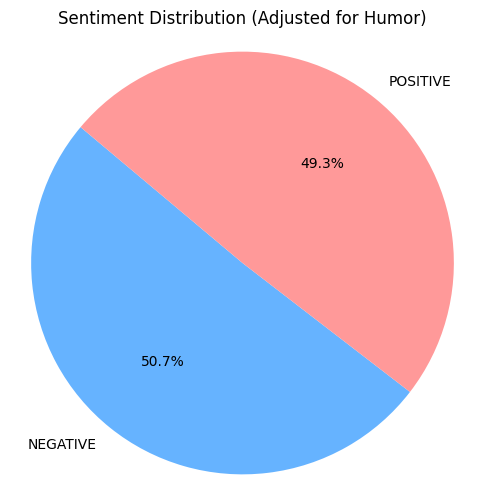

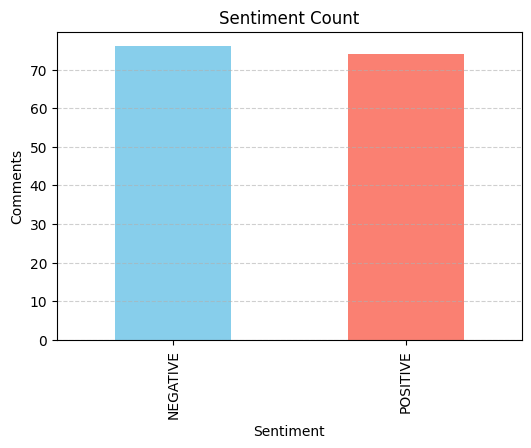

In [8]:
#performing on comments obtained 
channel_id = "UCRFj4Yj1nKhgrT-_8AUsaDg"
video_ids = get_channel_video_ids(channel_id, max_results=3)

all_comments = []
for vid in video_ids:
    try:
        comments = get_video_comments(vid, max_comments=50)
        all_comments.extend(comments)
    except Exception as e:
        print(f"Error on video {vid}: {e}")

# Analyze with humor-aware logic
df = analyze_comments_with_humor(all_comments)

# View & visualize
print(df.head())
visualize_sentiment(df)
